# Use-case: Exploring perturbation effects

This tutorial shows how to perform the analysis we present in Figure 4 of the [pertpy preprint](https://www.biorxiv.org/content/10.1101/2024.08.04.606516v1). We will use the data from [Zhang et al. 2021](https://doi.org/10.1016/j.ccell.2021.09.010) to explore the perturbation effects of different treatments on triple-negative breast cancer. We will use the mean squared error (MSE) distance to compare the expression profiles of cells between the different treatment-response groups. Additionally, we will use scCODA to identify changes in cell type composition between the different treatment groups.

In [10]:
import warnings
warnings.filterwarnings("ignore")

import pertpy as pt
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Load and preprocess the data

In [11]:
adata = pt.dt.zhang_2021()
adata

AnnData object with n_obs × n_vars = 489490 × 27085
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster'

First, we will filter the data to only include tumor samples, no progression samples, and only samples with a partial response or stable disease. We will also filter out the samples with a mix of cell types, following the pre-processing steps in the original publication.

In [12]:
# Filter to tumor samples only
adata = adata[adata.obs["Origin"] == "t", :].copy()

# Filter out progression samples
adata = adata[adata.obs["Group"] != "Progression", :].copy()

# Subset to partial response and stable disease and rename PR and SD
adata = adata[adata.obs["Efficacy"].isin(["PR", "SD"]), :].copy()
adata.obs["Efficacy"] = adata.obs["Efficacy"].replace({"PR": "Partial response", "SD": "Stable disease"})

# Filter out Mix samples
adata = adata[adata.obs["Cluster"] != "Mix", :].copy()
adata

AnnData object with n_obs × n_vars = 146358 × 27085
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster'

Now, we will refine the grouping to include both the timepoint and the treatment response.

In [13]:
adata.obs["Timepoint"] = adata.obs["Group"].copy()
adata.obs["Group"] = [f"{timepoint.split('-')[0]}-treat., {response}" for timepoint, response in zip(adata.obs["Timepoint"], adata.obs["Efficacy"])]
adata.obs["Group"].value_counts()

Group
Pre-treat., Partial response     57295
Post-treat., Stable disease      31626
Post-treat., Partial response    29659
Pre-treat., Stable disease       27778
Name: count, dtype: int64

After filtering, we do some standard pre-processing steps:

In [14]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor="seurat_v3")

In [15]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 146358 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', 'Timepoint'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'

In [16]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)

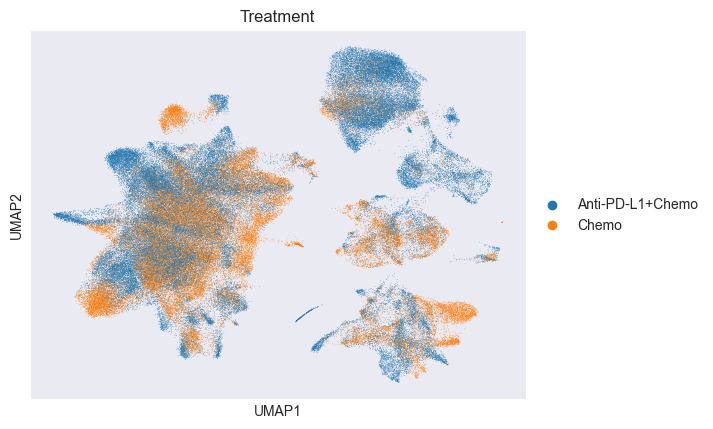

In [17]:
sc.pl.umap(adata, color="Treatment")

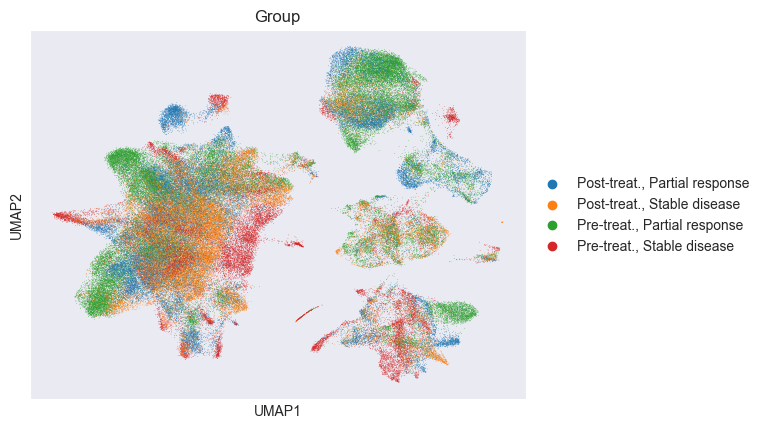

In [18]:
sc.pl.umap(adata, color="Group")

The dataset comes with a very detailed cell type annotation. We will use this annotation to define a coarser cell type annotation:

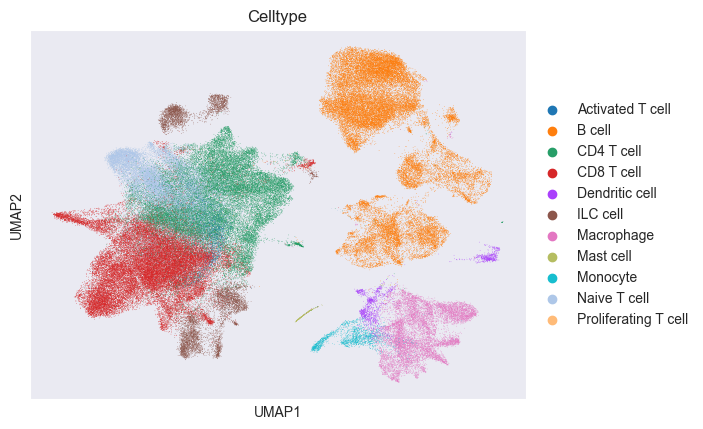

In [19]:
cell_type_converter = {
    "t_Bfoc": "B cell",
    "t_Bmem": "B cell",
    "t_Bn": "B cell",
    "t_CD4": "CD4 T cell",
    "t_CD8": "CD8 T cell",
    "t_ILC": "ILC cell",
    "t_Tact": "Activated T cell",
    "t_Tn": "Naive T cell",
    "t_Tprf": "Proliferating T cell",
    "t_cDC": "Dendritic cell",
    "t_mDC": "Dendritic cell",
    "t_macro": "Macrophage",
    "t_mast": "Mast cell",
    "t_mono": "Monocyte",
    "t_pB": "B cell",
    "t_pDC": "Dendritic cell",
}

cell_types = []
for ct in adata.obs["Cluster"]:
    for key, value in cell_type_converter.items():
        if ct.startswith(key):
            cell_types.append(value)
            break
    else:
        cell_types.append("n.a.")
adata.obs["Celltype"] = cell_types

sc.pl.umap(adata, color="Celltype")

We will further define a function to filter the data to only include cell types that are present in all groups. This function is used to create adatas for the different treatment groups. We will use those for the distance metric analysis, as well as for the compositional analysis.

In [20]:
def subset_to_common_cell_types(adata_temp):
    isecs = pd.crosstab(adata_temp.obs["Cluster"], adata_temp.obs["Group"])
    celltypes = isecs[(isecs >0).all(axis=1)].index.values.tolist()
    adata_temp = adata_temp[adata_temp.obs["Cluster"].isin(celltypes)]
    return adata_temp

In [21]:
adata_chemo = adata[adata.obs["Treatment"] == "Chemo"]
adata_chemo = subset_to_common_cell_types(adata_chemo)
adata_chemo.obs["Group"].value_counts()

Group
Post-treat., Stable disease      20659
Pre-treat., Partial response     16827
Post-treat., Partial response    12137
Pre-treat., Stable disease       11807
Name: count, dtype: int64

In [22]:
adata_chemo_pdl1 = adata[adata.obs["Treatment"] == "Anti-PD-L1+Chemo"]
adata_chemo_pdl1 = subset_to_common_cell_types(adata_chemo_pdl1)
adata_chemo_pdl1.obs["Group"].value_counts()

Group
Pre-treat., Partial response     40251
Post-treat., Partial response    16379
Pre-treat., Stable disease       13435
Post-treat., Stable disease      10717
Name: count, dtype: int64

## Using a distance metric to rank perturbation effects

Pertpy offers various distance metrics to compare the expression profile of cells between different groups, usually different perturbations. Here, we will use the mean squared error (MSE) distance to compare the expression profiles of cells between the different treatment-response groups. Importantly, we will do this for the full dataset, as well as for the chemo and chemo + anti-PD-L1 groups separately. This allows us to identify potential differences in the perturbation effects between the two treatment groups.

In [23]:
distance = pt.tl.Distance("mse", obsm_key="X_pca")
df_all = distance.pairwise(adata, groupby="Group", show_progressbar=False)

df_chemo = distance.pairwise(adata_chemo, groupby="Group", show_progressbar=False)

df_chemo_pdl1 = distance.pairwise(adata_chemo_pdl1, groupby="Group", show_progressbar=False)

In [24]:
# We need the global max and min to ensure that the color scale is the same for all heatmaps
global_max = max(df_all.max(axis=None), df_chemo.max(axis=None), df_chemo_pdl1.max(axis=None))
global_min = min(df_all.min(axis=None), df_chemo.min(axis=None), df_chemo_pdl1.min(axis=None))
order = df_all.index.values

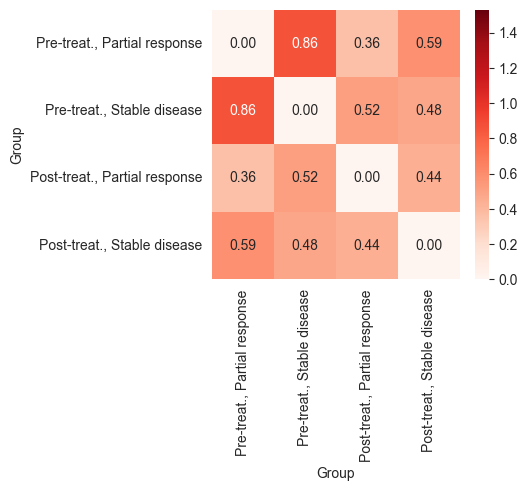

In [25]:
_, ax = plt.subplots(figsize=(4, 3.5))
sns.heatmap(df_all, annot=True, fmt=".2f", vmin=global_min, vmax=global_max, cmap="Reds", ax=ax)
plt.show()

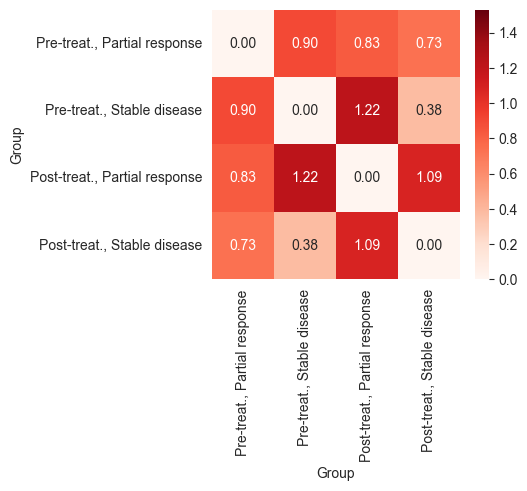

In [26]:
df_chemo = df_chemo.loc[order, order]
_, ax = plt.subplots(figsize=(4, 3.5))
sns.heatmap(df_chemo, annot=True, fmt=".2f", vmin=global_min, vmax=global_max, cmap="Reds", ax=ax)
plt.show()

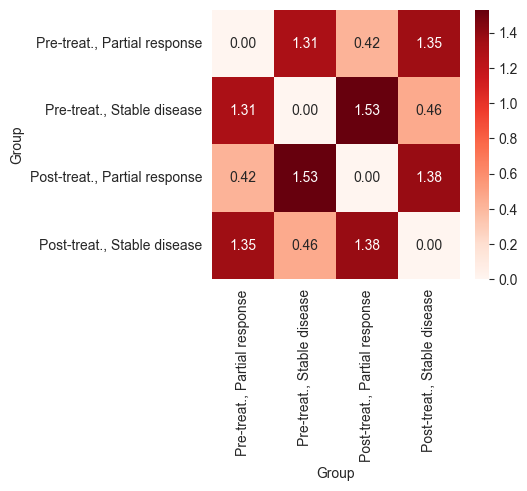

In [27]:
df_chemo_pdl1 = df_chemo_pdl1.loc[order, order]
_, ax = plt.subplots(figsize=(4, 3.5))
sns.heatmap(df_chemo_pdl1, annot=True, fmt=".2f", vmin=global_min, vmax=global_max, cmap="Reds", ax=ax)
plt.show()

The heatmaps above show that patients who responded to chemotherapy showed a larger difference between their pre- and post-treatment expression profiles compared to those who responded to the combination of anti-PDL-1 and chemotherapy. This indicates that the combination therapy may have led to a less intense response or was applied in cases with poorer prognoses.

## Identifying changes in cell type composition using scCODA

scCODA is a Bayesian model that allows to identify changes in cell type composition. Here, we will use scCODA to identify changes in cell type composition between the different treatment groups. We will run, analogous to the analysis set-up for the distance metric calculation, scCODA for each treatment (Chemo and Anti-PD-L1+Chemo) separately. However, we want to use the same reference cell type in order to be able to compare the results. Hence, we will first prepare the scCODA model on all data to identify a reference cell type:

In [28]:
# Get reference cell type
sccoda_model = pt.tl.Sccoda()

sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="Cluster",
    sample_identifier="Sample",
    covariate_obs=["Group"],
)

sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula=f"Group",
    reference_cell_type="automatic",
    automatic_reference_absence_threshold=0.1,
)

💡 Automatic reference selection! Reference cell type set to t_mono-FCN1
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


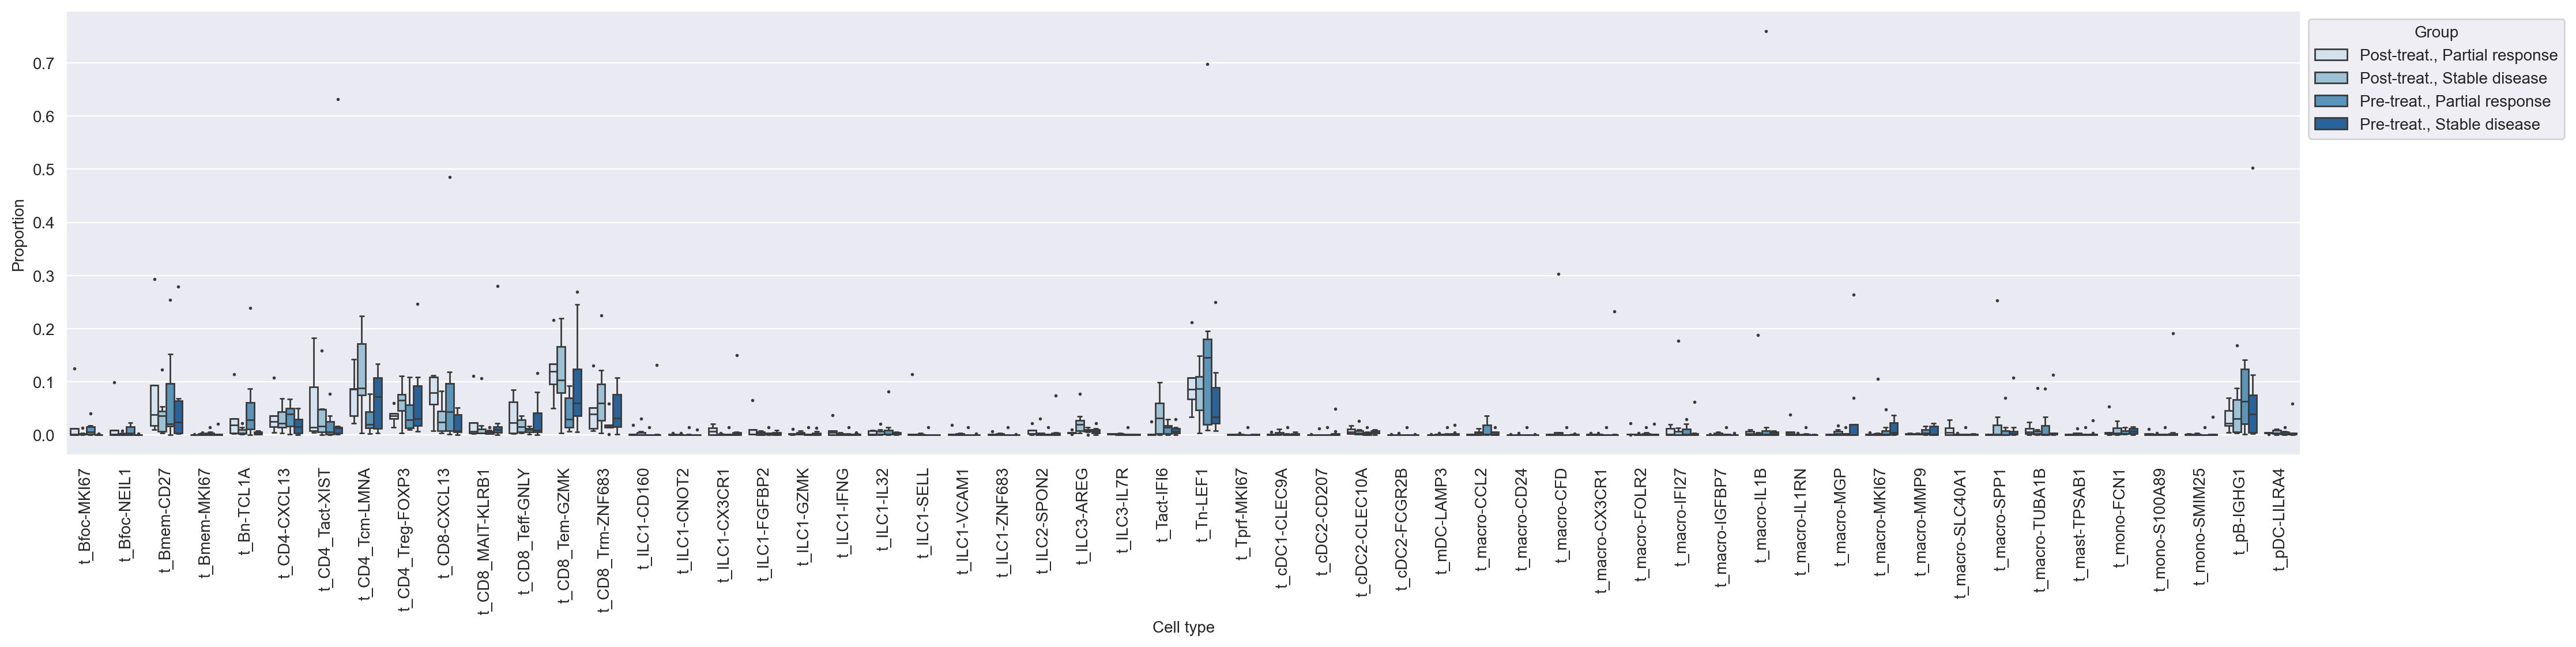

In [29]:
fig = sccoda_model.plot_boxplots(
    sccoda_data,
    modality_key="coda",
    feature_name="Group",
    return_fig=True,
    show=False,
)
fig.set_size_inches(25, 5)
fig.set_dpi(200)
fig.show()

The monocyte cell type is identified as the reference cell type. We will now run scCODA for the chemo and chemo + anti-PD-L1 groups separately, using the monocyte cell type as the reference cell type.

In [32]:
sccoda_model = pt.tl.Sccoda()

def run_sccoda(subset, reference):
    sccoda_data = sccoda_model.load(
        subset,
        type="cell_level",
        generate_sample_level=True,
        cell_type_identifier="Cluster",
        sample_identifier="Sample",
        covariate_obs=["Group"],
    )

    sccoda_data = sccoda_model.prepare(
        sccoda_data,
        modality_key="coda",
        formula=f"C(Group, Treatment('{reference}'))",
        reference_cell_type="t_mono-FCN1",  #"automatic",
        automatic_reference_absence_threshold=0.1,
    )

    sccoda_model.run_nuts(sccoda_data, modality_key="coda")
    sccoda_model.set_fdr(sccoda_data, modality_key="coda", est_fdr=0.1)

    comparison_groups = [g for g in subset.obs["Group"].unique() if g != reference]
    effect_df = pd.DataFrame(
        {"log2-fold change": [], "Cell Type": [], "Reference": [], "Comp. Group": [], "Final Parameter": []})
    for comp_group in comparison_groups:
        group_effects = sccoda_data["coda"].varm[f"effect_df_C(Group, Treatment('{reference}'))[T.{comp_group}]"][
            ["log2-fold change", "Final Parameter"]]
        group_effects = group_effects[group_effects["Final Parameter"] != 0]
        group_effects["Cell Type"] = group_effects.index
        group_effects["Reference"] = reference
        group_effects["Comp. Group"] = comp_group
        effect_df = pd.concat([effect_df, group_effects])
        
    if not effect_df.empty:
        fig = sccoda_model.plot_effects_barplot(sccoda_data, return_fig=True, show=False)
        fig.set_size_inches(12, 4)
        fig.show()
    else:
        print(f"No significant effects for reference {reference}")

    return effect_df

Pre-treat., Stable disease
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [02:14<00:00, 81.75it/s, 127 steps of size 2.63e-02. acc. prob=0.89]


Pre-treat., Partial response
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [02:17<00:00, 80.06it/s, 127 steps of size 3.40e-02. acc. prob=0.85]


No significant effects for reference Pre-treat., Partial response
Post-treat., Stable disease
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [02:19<00:00, 79.04it/s, 127 steps of size 2.78e-02. acc. prob=0.87]


Post-treat., Partial response
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [02:09<00:00, 84.70it/s, 127 steps of size 3.30e-02. acc. prob=0.79]


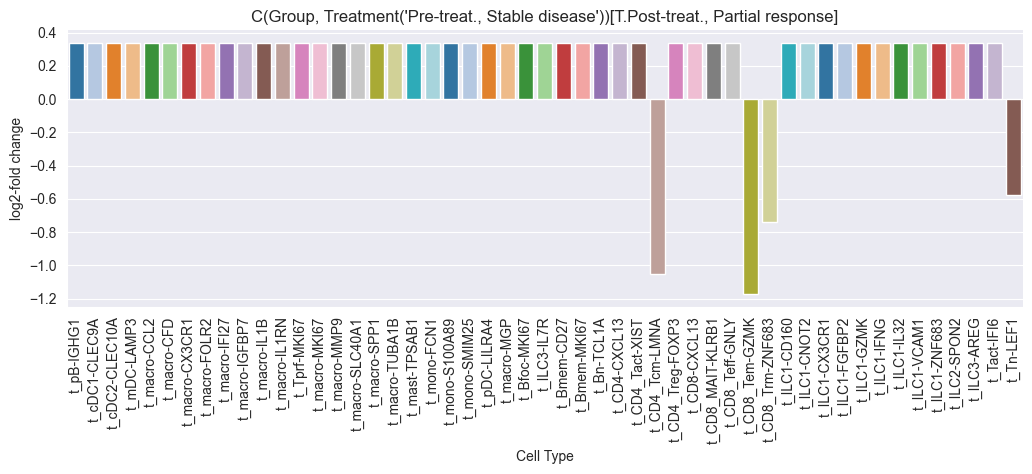

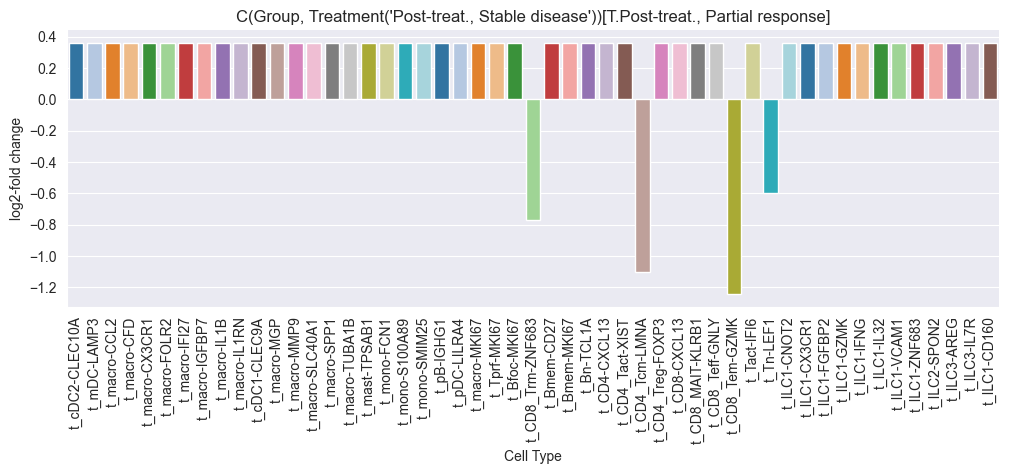

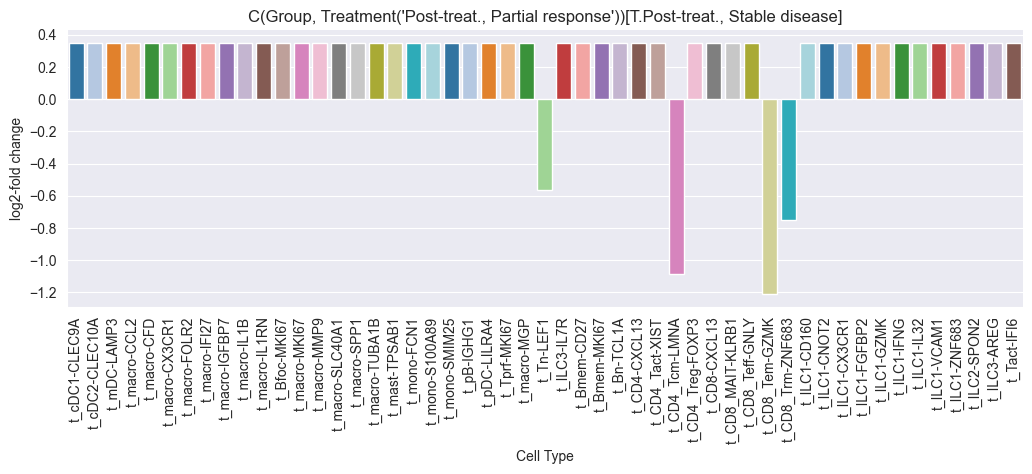

In [33]:
credible_effects_chemo = pd.DataFrame(
    {"log2-fold change": [], "Cell Type": [], "Reference": [], "Comp. Group": [], "Final Parameter": []})

for reference in adata_chemo.obs["Group"].unique():
    print(reference)
    effect_df_chemo = run_sccoda(adata_chemo, reference=reference)
    credible_effects_chemo = pd.concat([credible_effects_chemo, effect_df_chemo])

In [34]:
credible_effects_chemo

,log2-fold change,Cell Type,Reference,Comp. Group,Final Parameter
t_CD4_Tcm-LMNA,-1.051869,t_CD4_Tcm-LMNA,"Pre-treat., Stable disease","Pre-treat., Partial response",-0.963443
t_CD8_Tem-GZMK,-1.173683,t_CD8_Tem-GZMK,"Pre-treat., Stable disease","Pre-treat., Partial response",-1.047878
t_CD8_Trm-ZNF683,-0.737895,t_CD8_Trm-ZNF683,"Pre-treat., Stable disease","Pre-treat., Partial response",-0.745813
t_Tn-LEF1,-0.577472,t_Tn-LEF1,"Pre-treat., Stable disease","Pre-treat., Partial response",-0.634616
t_CD4_Tcm-LMNA,-1.099619,t_CD4_Tcm-LMNA,"Post-treat., Stable disease","Pre-treat., Partial response",-1.012419
t_CD8_Tem-GZMK,-1.243750,t_CD8_Tem-GZMK,"Post-treat., Stable disease","Pre-treat., Partial response",-1.112323
t_CD8_Trm-ZNF683,-0.768398,t_CD8_Trm-ZNF683,"Post-treat., Stable disease","Pre-treat., Partial response",-0.782834
t_Tn-LEF1,-0.599843,t_Tn-LEF1,"Post-treat., Stable disease","Pre-treat., Partial response",-0.666001
t_CD4_Tcm-LMNA,-1.084423,t_CD4_Tcm-LMNA,"Post-treat., Partial response","Pre-treat., Partial response",-0.994157
t_CD8_Tem-GZMK,-1.210772,t_CD8_Tem-GZMK,"Post-treat., Partial response","Pre-treat., Partial response",-1.081735


Multiple credible effects were found for the chemo treatment group. We will now run scCODA for the Anti-PD-L1 + Chemo group.

In [35]:
credible_effects_chemo_pdl1 = pd.DataFrame(
    {"log2-fold change": [], "Cell Type": [], "Reference": [], "Comp. Group": [], "Final Parameter": []})

for reference in adata_chemo_pdl1.obs["Group"].unique():
    print(reference)
    effect_df_chemo_pdl1 = run_sccoda(adata_chemo_pdl1, reference=reference)
    credible_effects_chemo_pdl1 = pd.concat([credible_effects_chemo_pdl1, effect_df_chemo_pdl1])

Pre-treat., Partial response
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [02:08<00:00, 85.74it/s, 127 steps of size 4.46e-02. acc. prob=0.71]


No significant effects for reference Pre-treat., Partial response
Pre-treat., Stable disease
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [02:12<00:00, 82.78it/s, 127 steps of size 3.73e-02. acc. prob=0.77]


No significant effects for reference Pre-treat., Stable disease
Post-treat., Partial response
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [02:09<00:00, 84.65it/s, 127 steps of size 3.12e-02. acc. prob=0.92]


No significant effects for reference Post-treat., Partial response
Post-treat., Stable disease
💡 Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [02:07<00:00, 86.24it/s, 127 steps of size 3.74e-02. acc. prob=0.75]


No significant effects for reference Post-treat., Stable disease


In [36]:
credible_effects_chemo_pdl1

,log2-fold change,Cell Type,Reference,Comp. Group,Final Parameter


For the Anti-PD-L1 + Chemo treatment group, no credible effects, i.e. changes in cell type composition, were found.

This fits to our earlier findings from the distance metric analysis, where we observed that the Anti-PD-L1 + Chemo group showed a smaller difference between their pre- and post-treatment expression profiles compared to the Chemo group. Overall, these findings indicate that the Anti-PD-L1 + Chemo combination therapy may have led to a less intense response or was applied in cases with poorer prognoses.